## Tutorial for Supervised and Unsupervised Learning on Simulations of a Retro Aldolase

In this jupyter notebook we will use the model_building.py module to identify differences in the molecular interactions for a retro aldolase when it is in a catatlytically competent state and when it is 


across PTP1B
when the WPD-loop of PTP1B is in the Closed state, versus when the WPD-loop is in the Open state.
This notebook will also cover all the pre- and post-processing steps requireds to prepare, analyse and visualise the results.

The dataset used here is for PTP1B is the same as what we used in the manuscript. 

<center><img src="miscellaneous/TODO.png" alt="Drawing" style="width: 70%" /></center>

In [2]:
import sys # note temporary... 
sys.path.append("..") # note temporary...

import pandas as pd
import numpy as np

from key_interactions_finder import pycontact_processing
from key_interactions_finder import data_preperation
from key_interactions_finder import model_building
from key_interactions_finder import post_proccessing
from key_interactions_finder import pymol_projections

### Step 1. Process PyContact files with the pycontact_processing.py module 

In this section we will work with the PyContact output files generated. 
Here we will merge our seperate runs together and remove any false interactions that can be generated by the PyContact library. 

In [3]:
pycontact_files_horizontal = ["PyContact_Per_Frame_Interactions_Block1.csv", "PyContact_Per_Frame_Interactions_Block2.csv",
                              "PyContact_Per_Frame_Interactions_Block3.csv", "PyContact_Per_Frame_Interactions_Block4.csv",
                              "PyContact_Per_Frame_Interactions_Block5.csv", "PyContact_Per_Frame_Interactions_Block6.csv",
                              "PyContact_Per_Frame_Interactions_Block7.csv", "PyContact_Per_Frame_Interactions_Block8.csv",
                              "PyContact_Per_Frame_Interactions_Block9.csv", "PyContact_Per_Frame_Interactions_Block10.csv",
                              "PyContact_Per_Frame_Interactions_Block11.csv", "PyContact_Per_Frame_Interactions_Block12.csv",
                              "PyContact_Per_Frame_Interactions_Block13.csv", "PyContact_Per_Frame_Interactions_Block14.csv",
                              "PyContact_Per_Frame_Interactions_Block15.csv", "PyContact_Per_Frame_Interactions_Block16.csv",
                              "PyContact_Per_Frame_Interactions_Block17.csv"]

pycontact_dataset = pycontact_processing.PyContactInitializer(
    pycontact_files=pycontact_files_horizontal,
    multiple_files=True,
    merge_files_method="horizontal",  
    remove_false_interactions=True,
    in_dir="datasets/retrol_aldolase_data/",
)

Your PyContact file(s) have been succefully processed.
You have 3056 features and 10000 observations.
The fully processed dataframe is accesible from the '.prepared_df' class attribute.


In [4]:
# As outputted above, we can inspect the newly prepared dataset by accessing the '.prepared_df' class attribute as follows:
pycontact_dataset.prepared_df

,1Pro 140Glu Hbond bb-sc,1Pro 135Ile Hbond bb-bb,1Pro 136Leu Hbond bb-bb,1Pro 113Val Hydrophobic sc-sc,1Pro 12Val Hydrophobic sc-sc,1Pro 137Thr Hbond bb-sc,1Pro 3Tyr Hbond bb-bb,2Arg 137Thr Hbond sc-bb,2Arg 140Glu Hbond bb-sc,2Arg 136Leu Hbond sc-bb,...,242Ile 212Ile Other bb-sc,246Ile 46Ala Other sc-bb,242Ile 234Ser Other sc-bb,244Glu 222Arg Other bb-sc,241Lys 211Gly Other sc-bb,241Lys 71Phe Other bb-sc,246Ile 77Val Other sc-bb,242Ile 237Arg Other sc-bb,245Leu 44Ile Other bb-sc,242Ile 48Ile Other sc-bb
0,10.69070,2.69143,3.20350,3.28620,1.36506,0.74495,0.64727,3.34225,0.87675,9.87756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.47441,3.23497,4.82080,1.07496,0.25386,2.58459,0.45446,2.34583,0.45081,9.17317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.11200,1.66876,1.58322,2.21242,0.02944,1.15886,0.81023,2.03891,0.84995,6.66903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.28064,3.30286,1.54644,0.05986,0.96466,2.25997,0.43410,1.61199,0.36436,7.82080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.54559,2.78183,1.79891,0.27192,0.44629,1.13325,0.74145,0.25292,0.07107,2.40651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10.43428,2.87244,0.37792,0.84401,1.36240,0.45684,0.79760,4.82421,0.83238,8.17372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,7.96627,3.38587,0.16006,0.06228,0.51337,4.56594,0.10768,4.04402,0.00000,5.07718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,7.35284,3.23050,0.00974,0.76542,0.93003,0.90531,0.45525,3.65877,0.09956,10.29806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,7.92164,2.47504,0.27218,0.00000,0.10206,2.02611,0.10234,1.57470,0.01281,5.87328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Step 2 Prepare the Dataset for Statistical Analysis with the data_preperation.py module. 

In this step, we take our dataframe and merge our per frame classifications file to it.
We can also optionally perform several forms of filtering to select what types of interactions we
would like to study.  

In [5]:
# First we generate an instance of the SupervisedFeatureData class (because we have per frame class labels).

classifications_file = "datasets/retrol_aldolase_data/4a2s_RA95_5_Classifications.txt"

supervised_dataset = data_preperation.SupervisedFeatureData(
    input_df=pycontact_dataset.prepared_df,
    classifications_file=classifications_file,
    header_present=True # If your classifications_file has a header present, set to True.
)

Your features and class datasets have been succesufully merged.
You can access this dataset through the class attribute: '.df_feat_class'.


In [6]:
# As stated above to access the newly generated dataframe we can use the class attribute as follows
supervised_dataset.df_feat_class 

,Classes,1Pro 140Glu Hbond bb-sc,1Pro 135Ile Hbond bb-bb,1Pro 136Leu Hbond bb-bb,1Pro 113Val Hydrophobic sc-sc,1Pro 12Val Hydrophobic sc-sc,1Pro 137Thr Hbond bb-sc,1Pro 3Tyr Hbond bb-bb,2Arg 137Thr Hbond sc-bb,2Arg 140Glu Hbond bb-sc,...,242Ile 212Ile Other bb-sc,246Ile 46Ala Other sc-bb,242Ile 234Ser Other sc-bb,244Glu 222Arg Other bb-sc,241Lys 211Gly Other sc-bb,241Lys 71Phe Other bb-sc,246Ile 77Val Other sc-bb,242Ile 237Arg Other sc-bb,245Leu 44Ile Other bb-sc,242Ile 48Ile Other sc-bb
0,NotCatComp,10.69070,2.69143,3.20350,3.28620,1.36506,0.74495,0.64727,3.34225,0.87675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NotCatComp,11.47441,3.23497,4.82080,1.07496,0.25386,2.58459,0.45446,2.34583,0.45081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NotCatComp,10.11200,1.66876,1.58322,2.21242,0.02944,1.15886,0.81023,2.03891,0.84995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NotCatComp,9.28064,3.30286,1.54644,0.05986,0.96466,2.25997,0.43410,1.61199,0.36436,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NotCatComp,8.54559,2.78183,1.79891,0.27192,0.44629,1.13325,0.74145,0.25292,0.07107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,CatComp,10.43428,2.87244,0.37792,0.84401,1.36240,0.45684,0.79760,4.82421,0.83238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,CatComp,7.96627,3.38587,0.16006,0.06228,0.51337,4.56594,0.10768,4.04402,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,CatComp,7.35284,3.23050,0.00974,0.76542,0.93003,0.90531,0.45525,3.65877,0.09956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,CatComp,7.92164,2.47504,0.27218,0.00000,0.10206,2.02611,0.10234,1.57470,0.01281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Optional Feature Filtering

In the above dataframe we have 3057 columns (so 3057 features). We can take all of these forward for the stastical analysis or we can perform some filtering in advance (the choice is yours). 
There are four built in filtering methods available to you:

1. filter_by_occupancy(min_occupancy) - Remove features that have an %occupancy less than the provided cut-off. %Occupancy is the % of frames with a non 0 value, i.e. the interaction is present in that frame.

2. filter_by_interaction_type(interaction_types_included). - PyContact defines four types of interactions ("Hbond", "Saltbr", "Hydrophobic", "Other"). You select the interactions your want to INCLUDE.

3. filter_by_main_or_side_chain(main_side_chain_types_included) PyContact can also define if each interaction is primarily from the backbone or side-chain for each residue. You select the interaction combinations you want to INCLUDE. Options are: "bb-bb", "sc-sc", "bb-sc", "sc-bb". Where bb = backbone and sc = sidechain.

4. filter_by_avg_strength(average_strength_cut_off) - PyContact calculates a per frame contact score/strength for each interaction. You can filter features by the average score. Values below the cut-off are removed. 

5. reset_filtering() - This method allows you to reset any filtering commands you have already called. (i.e. resets the filtered dataframe back to the unfiltered dataframe.)


In [7]:
# An example of filtering the dataset using the 4 available methods. 

print(f"Number of features before any filtering: {len(supervised_dataset.df_feat_class.columns)}")

# Features with a %occupancy of less than 25% are removed. 
supervised_dataset.filter_by_occupancy(min_occupancy=25)
print(f"Number of features after filtering by occupancy: {len(supervised_dataset.df_filtered.columns)}")

# No filtering performed here as all possible combinations are included. 
supervised_dataset.filter_by_interaction_type(
    interaction_types_included=["Hbond"]) # "Saltbr", "Hydrophobic", "Other" #TODO put back
print(f"Number of features after NOT filtering by interaction type: {len(supervised_dataset.df_filtered.columns)}")

# No filtering performed here as all possible combinations are included. 
supervised_dataset.filter_by_main_or_side_chain(
    main_side_chain_types_included=["bb-bb", "sc-sc", "bb-sc", "sc-bb"]  
)
print(f"Number of features after NOT filtering by main or side chain: {len(supervised_dataset.df_filtered.columns)}")

# Features with average interaction scores less than 0.5 will be removed. 
supervised_dataset.filter_by_avg_strength(
    average_strength_cut_off=0.5,  
)
print(f"Number of features after filtering by average interaction scores: {len(supervised_dataset.df_filtered.columns)}")

Number of features before any filtering: 3057
Number of features after filtering by occupancy: 1413
Number of features after NOT filtering by interaction type: 796
Number of features after NOT filtering by main or side chain: 796
Number of features after filtering by average interaction scores: 717


Now if we look at the class attributes of our SupervisedFeatureData() instance (we called it: supervised_dataset) using the special "\_\_dict__" method we can see two dataframes we could use in the machine learning to follow. 

In [8]:
supervised_dataset.__dict__.keys()

dict_keys(['input_df', 'classifications_file', 'header_present', 'df_feat_class', 'df_filtered'])

They are: 
- 'df_feat_class' - The unfiltered dataframe, 3057 features
- 'df_filtered' - The filtered dataframe. Less than 3057 features. 

In the following section we will use the filtered dataframe.

### Step 3. Perform the Machine Learning with the model_building.py module. 

Now we will setup and run the supervised machine learning (ML) on the retro aldolase enzyme. Here we will apply to ML to distinguish between catalytically active and inactive conformations of the enzyme towards catalysis of XXXX. 

Describe the ML in more detail TODO

In [9]:
supervised_dataset.df_filtered["Classes"].value_counts()

NotCatComp    5571
CatComp       3840
Neither        589
Name: Classes, dtype: int64

In [10]:
# Instantiate the model.
ml_model = model_building.SupervisedModel(
    dataset=supervised_dataset.df_filtered,
    evaluation_split_ratio=0.15,
    classes_to_use=["CatComp", "NotCatComp"],
    models_to_use=["CatBoost", "Random_Forest"],
    scaling_method="min_max",
    out_dir="outputs/retro_aldol_ml",
    cross_validation_splits=5,
    cross_validation_repeats=3,
    search_approach="none",
)


Below is a summary of the machine learning you have planned.
You will use 5-fold cross validation and perform 3 repeats.
You will use up to 717 features to build each model, with 85.0% of your data used for training the model, which is 7999 observations. 
15.0% of your data will be used for evaluating the best models produced by the 5-fold cross validation, which is 1412 observations.
You have chosen to build 2 different machine learning models, each with the following hyperparameters: 
 
A CatBoost model, with grid search parameters: 
{'model': <catboost.core.CatBoostClassifier object at 0x0000011F7C52A340>, 'params': {'iterations': [50]}} 

A Random_Forest model, with grid search parameters: 
{'model': RandomForestClassifier(), 'params': {'n_estimators': [1]}} 

If you're happy with the above, lets get model building!


In [11]:
# Build the models.
# TODO - EXPLAIN SAVE OPTION....
ml_model.build_models(save_models=True)

Learning rate set to 0.354967
0:	learn: 0.4901096	total: 238ms	remaining: 11.7s
1:	learn: 0.3965163	total: 338ms	remaining: 8.12s
2:	learn: 0.3322211	total: 417ms	remaining: 6.53s
3:	learn: 0.3036592	total: 505ms	remaining: 5.8s
4:	learn: 0.2642576	total: 588ms	remaining: 5.3s
5:	learn: 0.2437502	total: 680ms	remaining: 4.99s
6:	learn: 0.2271037	total: 773ms	remaining: 4.75s
7:	learn: 0.2145043	total: 867ms	remaining: 4.55s
8:	learn: 0.2001881	total: 960ms	remaining: 4.37s
9:	learn: 0.1844874	total: 1.05s	remaining: 4.2s
10:	learn: 0.1779808	total: 1.16s	remaining: 4.12s
11:	learn: 0.1716954	total: 1.27s	remaining: 4.02s
12:	learn: 0.1665962	total: 1.38s	remaining: 3.92s
13:	learn: 0.1628801	total: 1.47s	remaining: 3.77s
14:	learn: 0.1575246	total: 1.56s	remaining: 3.65s
15:	learn: 0.1538033	total: 1.65s	remaining: 3.52s
16:	learn: 0.1488929	total: 1.76s	remaining: 3.42s
17:	learn: 0.1444806	total: 1.85s	remaining: 3.29s
18:	learn: 0.1403445	total: 1.94s	remaining: 3.17s
19:	learn: 0.1

With the models now built, we can see the models seem to be xxxxx

We can now evaluate the quality of the models on the validation dataset. Again, thankfully the accuracy is quite high.  

In [12]:
# Evaluate model quality
print(ml_model.evaluate_models())

Classification report for the CatBoost model:
              precision    recall  f1-score   support

     CatComp       0.96      0.94      0.95       586
  NotCatComp       0.96      0.97      0.97       826

    accuracy                           0.96      1412
   macro avg       0.96      0.96      0.96      1412
weighted avg       0.96      0.96      0.96      1412

Classification report for the Random_Forest model:
              precision    recall  f1-score   support

     CatComp       0.74      0.71      0.73       586
  NotCatComp       0.80      0.82      0.81       826

    accuracy                           0.78      1412
   macro avg       0.77      0.77      0.77      1412
weighted avg       0.78      0.78      0.78      1412

None


Another popular way to evaluate model quality is to generate confusion matrices. 

We can do that as well as shown below. 
You can easily plot these confusion matrices in whatever graphing program you like, but in this case, I will use seaborn.

In [18]:
confusion_matrices = ml_model.generate_confusion_matrix()

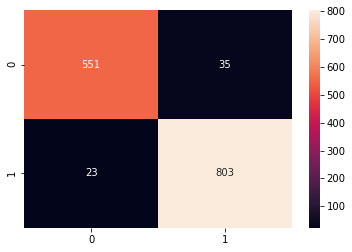

In [25]:
import seaborn as sns
ax = sns.heatmap(confusion_matrices["CatBoost"], annot=True, fmt="d")

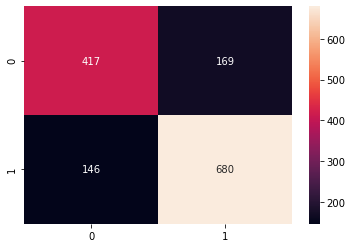

In [26]:
ax = sns.heatmap(confusion_matrices["Random_Forest"], annot=True, fmt="d")

### Step 4 Work up the Machine Learning with the post_proccessing.py module. 

With this module, we can analyse our results in more detail to understand what features each model determined where important for distignugshing between each state. 

In order to perform the analysis we will need to load in the models previously generated. 

In [19]:
# First we will make an instance of the SupervisedPostProcessor class.
post_proc = post_proccessing.SupervisedPostProcessor(
    out_dir="outputs/retro_aldol_ml",
)

# Option 1 - Load models from the instance of the SupervisedModel class. 
post_proc.load_models_from_instance(supervised_model=ml_model)

# Option 2 - Load models from disk.
post_proc.load_models_from_disk(models_to_use=["CatBoost", "Random_Forest"]) # "Ada_Boost"

In [20]:
# After preparing the class we can now determine the feature importances for each model.
post_proc.get_feature_importance()

outputs/retro_aldol_ml/CatBoost_Feature_Importances.csv written to disk.
outputs/retro_aldol_ml/Random_Forest_Feature_Importances.csv written to disk.
All feature importances written to disk.


In [21]:
# We can also project these per feature importances onto the per-residue level. 
# This is done by summing each residues features importances and normalising so that the residue
#  with the greatest overall  
post_proc.get_per_res_importance()

outputs/retro_aldol_ml/CatBoost_Per_Residue_Importances.csv written to disk.
outputs/retro_aldol_ml/Random_Forest_Per_Residue_Importances.csv written to disk.
All per residue feature importance scores were saved to disk.


In [22]:
# Again, if we take a look at the class attributes we can see the per feature and 
# per residue importances were not just saved to disk, but are also now stored in the class
# meaning you can analyse them here if you wish. 
print(post_proc.__dict__.keys())
all_per_res_scores = post_proc.all_per_residue_scores
all_feature_scores = post_proc.all_feature_importances

dict_keys(['out_dir', 'feat_names', 'best_models', 'all_feature_importances', 'all_per_residue_scores'])


### Part 5 Projecting the Results onto Protein Structures with the pymol_projections.py module. 
 
Naturally, we may want to visualise some of the results we have generated above onto a protein structure. We can take advantage of the functions provided in the pymol_projections.py module to do this. 

As the name suggests this will output [PyMOL](https://pymol.org/) compatible python scripts which can be run to represent the results at either the: 

1. Per feature level. (Cylinders are drawn between both residues in each feature, with the cylinder radii marking how large the relative importance is. 
2. Per residue level. The carbon alpha of each residue will be depicted as a sphere, with the sphere radii depicting the relative importance of the residue for the machine learning model.

In [23]:
pymol_projections.project_multiple_per_res_scores(
    all_per_res_scores=all_per_res_scores,
    out_dir="outputs/retro_aldol_ml"
)

The file: outputs/retro_aldol_ml/CatBoost_Pymol_Per_Res_Scores.py was written to disk.
The file: outputs/retro_aldol_ml/Random_Forest_Pymol_Per_Res_Scores.py was written to disk.


In [24]:
pymol_projections.project_multiple_per_feature_scores(
    all_feature_scores=all_feature_scores,
    numb_features="all",
    out_dir="outputs/retro_aldol_ml"
)

The file: outputs/retro_aldol_ml/CatBoost_Pymol_Per_Feature_Scores.py was written to disk.
The file: outputs/retro_aldol_ml/Random_Forest_Pymol_Per_Feature_Scores.py was written to disk.


In [ ]:
# TODO ADD Picture of the outputs here as an example. 